# Statlog (Image Segmentation) Data Set 

#### Data Set Information:

The instances were drawn randomly from a database of 7 outdoor images. The images were handsegmented to create a classification for every pixel. 

Each instance is a 3x3 region. 


#### Attribute Information:

1. region-centroid-col: the column of the center pixel of the region. 
2. region-centroid-row: the row of the center pixel of the region. 
3. region-pixel-count: the number of pixels in a region = 9. 
4. short-line-density-5: the results of a line extractoin algorithm that counts how many lines of length 5 (any orientation) with low contrast, less than or equal to 5, go through the region. 
5. short-line-density-2: same as short-line-density-5 but counts lines of high contrast, greater than 5. 
6. vedge-mean: measure the contrast of horizontally adjacent pixels in the region. There are 6, the mean and standard deviation are given. This attribute is used as a vertical edge detector. 
7. vegde-sd: (see 6) 
8. hedge-mean: measures the contrast of vertically adjacent pixels. Used for horizontal line detection. 
9. hedge-sd: (see 8). 
10. intensity-mean: the average over the region of (R + G + B)/3 
11. rawred-mean: the average over the region of the R value. 
12. rawblue-mean: the average over the region of the B value. 
13. rawgreen-mean: the average over the region of the G value. 
14. exred-mean: measure the excess red: (2R - (G + B)) 
15. exblue-mean: measure the excess blue: (2B - (G + R)) 
16. exgreen-mean: measure the excess green: (2G - (R + B)) 
17. value-mean: 3-d nonlinear transformation of RGB. (Algorithm can be found in Foley and VanDam, Fundamentals of Interactive Computer Graphics) 
18. saturatoin-mean: (see 17) 
19. hue-mean: (see 17) 

#### Classes: 
1. brickface, 
2. sky, 
3. foliage, 
4. cement, 
5. window, 
6. path, 
7. grass. 

# Contents Navigation
<ul>
    <li><a href="#Data-Load">Data Load</a></li>
    <li><a href="#Data-Preprocessing">Data Preprocessing</a></li>
    <li><a href="#Linear-Models">Linear Models</a></li>
    <li><a href="#SVM-with-non-linear-kernel">SVM with non-linear kernel</a></li>
    <li><a href="#KNN">KNN</a></li>
    <li><a href="#Random-Forest">Random Forest</a></li>
    <li><a href="#Neural-Network">Neural Network</a></li>
    <li><a href="#Summary">Summary</a></li>
</ul>

In [1]:
import pandas as pd

## Data Load

In [2]:
column_names = [
    'region-centroid-col', 
    'region-centroid-row', 
    'region-pixel-count',
    'short-line-density-5',
    'short-line-density-2',
    'vedge-mean',
    'vegde-sd',
    'hedge-mean',
    'hedge-sd',
    'intensity-mean',
    'rawred-mean',
    'rawblue-mean',
    'rawgreen-mean',
    'exred-mean',
    'exblue-mean',
    'exgreen-mean',
    'value-mean',
    'saturatoin-mean',
    'hue-mean',
    'classes',
]
# try to load data from local path
# if error occurred then trying to load data from UCI repo
try:
    df = pd.read_csv('data/segment.dat', sep='\s+', names=column_names)
except IOError:
    import urllib
    
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/segment/segment.dat"
    raw_data = urllib.urlopen(url)
    df = pd.read_csv(raw_data, names=column_names)

In [3]:
X = df.ix[:,:19]
y = df.ix[:,19]
X.shape, y.shape

((2310, 19), (2310,))

## Data Preprocessing

In [4]:
from sklearn import preprocessing, cross_validation

In [5]:
# preprocess continuous data
X_encoded = preprocessing.scale(X) # standardize of data, set zero mean and unit variance

# preprocess categorical data
encoder = preprocessing.OneHotEncoder()
y_encoded = encoder.fit_transform(y.values.reshape(-1,1)) # one-hot encoding

X_encoded.shape, y_encoded.shape

((2310, 19), (2310, 7))

### split data to train/test samples

In [6]:
# fix random seed for reproducibility
seed = 10

In [7]:
# split to train / test samples
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.3, random_state=seed)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1617, 19), (693, 19), (1617,), (693,))

In [8]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = cross_validation.train_test_split(
    X_encoded, y_encoded, test_size=0.3, random_state=seed)

X_train_encoded.shape, X_test_encoded.shape, y_train_encoded.shape, y_test_encoded.shape

((1617, 19), (693, 19), (1617, 7), (693, 7))

## Linear Models

In [9]:
from sklearn import grid_search, linear_model

In [10]:
# let's select most accurate linear model using grid search
cv = cross_validation.StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=seed)

parameters = {'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'penalty':['l2', 'l1', 'elasticnet']}

sgd = linear_model.SGDClassifier(random_state=seed)

### with raw data

In [11]:
grid = grid_search.GridSearchCV(
    sgd, parameters, scoring='accuracy', cv=cv).fit(X_train, y_train)

In [13]:
print 'Best training score: {}'.format(grid.best_score_)
print 'Best linear model params: {}'.format(grid.best_params_)

linear_score = grid.score(X_test, y_test)
print 'Accuracy score on test data: {}'.format(linear_score)

Best training score: 0.804347826087
Best linear model params: {'penalty': 'l1', 'loss': 'log'}
Accuracy score on test data: 0.777777777778


### with encoded data

In [14]:
grid2 = grid_search.GridSearchCV(
    sgd, parameters, scoring='accuracy', cv=cv).fit(X_train_encoded, y_train)

In [15]:
print 'Best training score: {}'.format(grid2.best_score_)
print 'Best linear model params: {}'.format(grid2.best_params_)

linear_score2 = grid2.score(X_test_encoded, y_test)
print 'Accuracy score on test data: {}'.format(linear_score2)

Best training score: 0.91801242236
Best linear model params: {'penalty': 'l1', 'loss': 'log'}
Accuracy score on test data: 0.901875901876


## SVM with non-linear kernel

In [16]:
from sklearn import svm

In [17]:
# we ignore linear svm because it implemented in SGDClassifier with loss='hinge'
parameters = {'kernel':('rbf', 'poly', 'sigmoid')}

### with raw data

In [18]:
svm_clf = grid_search.GridSearchCV(
    svm.SVC(), parameters, scoring='accuracy', cv=cv).fit(X_train, y_train)

In [19]:
print 'Best training score: {}'.format(svm_clf.best_score_)
print 'Best linear model params: {}'.format(svm_clf.best_params_)

svm_score = svm_clf.score(X_test, y_test)
print 'Accuracy score on test data: {}'.format(svm_score)

Best training score: 0.963354037267
Best linear model params: {'kernel': 'poly'}
Accuracy score on test data: 0.962481962482


### with encoded data

In [20]:
svm_clf2 = grid_search.GridSearchCV(
    svm.SVC(), parameters, scoring='accuracy', cv=cv).fit(X_train_encoded, y_train)

In [21]:
print 'Best training score: {}'.format(svm_clf2.best_score_)
print 'Best linear model params: {}'.format(svm_clf2.best_params_)

svm_score2 = svm_clf2.score(X_test_encoded, y_test)
print 'Accuracy score on test data: {}'.format(svm_score2)

Best training score: 0.93850931677
Best linear model params: {'kernel': 'rbf'}
Accuracy score on test data: 0.929292929293


## KNN

In [22]:
from sklearn import neighbors

### with raw data

In [23]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2, 
    algorithm='ball_tree').fit(X_train, y_train)

In [24]:
knn_score = knn.score(X_test, y_test)
print 'Accuracy score on test data: {}'.format(knn_score)

Accuracy score on test data: 0.939393939394


### with encoded data

In [25]:
knn2 = neighbors.KNeighborsClassifier(n_neighbors=2, 
    algorithm='ball_tree').fit(X_train_encoded, y_train)

In [26]:
knn_score2 = knn2.score(X_test_encoded, y_test)
print 'Accuracy score on test data: {}'.format(knn_score2)

Accuracy score on test data: 0.943722943723


## Random Forest

In [27]:
from sklearn import ensemble

### with raw data

In [28]:
tree = ensemble.RandomForestClassifier(
    n_estimators=60, criterion='entropy', max_depth=10, random_state=seed).fit(X_train, y_train)

In [29]:
tree_score = tree.score(X_test, y_test)
print 'Accuracy score on test data: {}'.format(tree_score)

Accuracy score on test data: 0.972582972583


### with encoded data

In [30]:
tree2 = ensemble.RandomForestClassifier(
    n_estimators=60, criterion='entropy', max_depth=10, random_state=seed).fit(X_train_encoded, y_train)

In [31]:
tree_score2 = tree2.score(X_test_encoded, y_test)
print 'Accuracy score on test data: {}'.format(tree_score2)

Accuracy score on test data: 0.974025974026


## Neural Network

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [33]:
# to avoid AttributeError: 'module' object has no attribute 'control_flow_ops'
# https://github.com/fchollet/keras/issues/3857#issuecomment-255156966
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.python.control_flow_ops = control_flow_ops

In [34]:
batch_size = 100
epochs = 300

In [35]:
# we apply diamond shape of network based on arguments contained 
# in unit 4.4. of this paper https://arxiv.org/pdf/1601.02376.pdf
model = Sequential()
model.add(Dense(38, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(38*2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(38, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### with raw data

In [36]:
history = model.fit(X_train.values, y_train_encoded.toarray(), nb_epoch=epochs, batch_size=batch_size, verbose=1)

Epoch 1/300
1617/1617 [==============================] - 0s - loss: 11.5452 - acc: 0.1775     
Epoch 2/300
1617/1617 [==============================] - 0s - loss: 9.7024 - acc: 0.2294     
Epoch 3/300
1617/1617 [==============================] - 0s - loss: 8.4000 - acc: 0.3006     
Epoch 4/300
1617/1617 [==============================] - 0s - loss: 7.3451 - acc: 0.2962     
Epoch 5/300
1617/1617 [==============================] - 0s - loss: 5.9415 - acc: 0.3315     
Epoch 6/300
1617/1617 [==============================] - 0s - loss: 4.5009 - acc: 0.3259     
Epoch 7/300
1617/1617 [==============================] - 0s - loss: 3.2806 - acc: 0.3383     
Epoch 8/300
1617/1617 [==============================] - 0s - loss: 2.3329 - acc: 0.3500     
Epoch 9/300
1617/1617 [==============================] - 0s - loss: 2.2292 - acc: 0.3228     
Epoch 10/300
1617/1617 [==============================] - 0s - loss: 1.9823 - acc: 0.3346     
Epoch 11/300
1617/1617 [==============================] - 

In [37]:
loss, accuracy = model.evaluate(X_test.values, y_test_encoded.toarray(), batch_size=batch_size)
print("Loss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

500/693 [====================>.........] - ETA: 0sLoss: 0.13, Accuracy: 95.82%


### with encoded data

In [38]:
model2 = Sequential()
model2.add(Dense(38, activation='relu', input_dim=X_train.shape[1]))
model2.add(Dropout(0.2))
model2.add(Dense(38*2, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(38, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(7,activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
history2 = model2.fit(X_train_encoded, y_train_encoded.toarray(), nb_epoch=epochs, batch_size=batch_size, verbose=1)

Epoch 1/300
1617/1617 [==============================] - 0s - loss: 1.8242 - acc: 0.2820     
Epoch 2/300
1617/1617 [==============================] - 0s - loss: 1.5336 - acc: 0.4607     
Epoch 3/300
1617/1617 [==============================] - 0s - loss: 1.2531 - acc: 0.5999     
Epoch 4/300
1617/1617 [==============================] - 0s - loss: 1.0278 - acc: 0.6685     
Epoch 5/300
1617/1617 [==============================] - 0s - loss: 0.8326 - acc: 0.7186     
Epoch 6/300
1617/1617 [==============================] - 0s - loss: 0.7214 - acc: 0.7489     
Epoch 7/300
1617/1617 [==============================] - 0s - loss: 0.6352 - acc: 0.7706     
Epoch 8/300
1617/1617 [==============================] - 0s - loss: 0.5667 - acc: 0.7984     
Epoch 9/300
1617/1617 [==============================] - 0s - loss: 0.5185 - acc: 0.8169     
Epoch 10/300
1617/1617 [==============================] - 0s - loss: 0.4680 - acc: 0.8355     
Epoch 11/300
1617/1617 [==============================] - 0

In [40]:
loss2, accuracy2 = model2.evaluate(X_test_encoded, y_test_encoded.toarray(), batch_size=batch_size)
print("Loss: %.2f, Accuracy: %.2f%%" % (loss2, accuracy2*100))

500/693 [====================>.........] - ETA: 0sLoss: 0.14, Accuracy: 96.97%


### visualizing learning/loss curve

In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

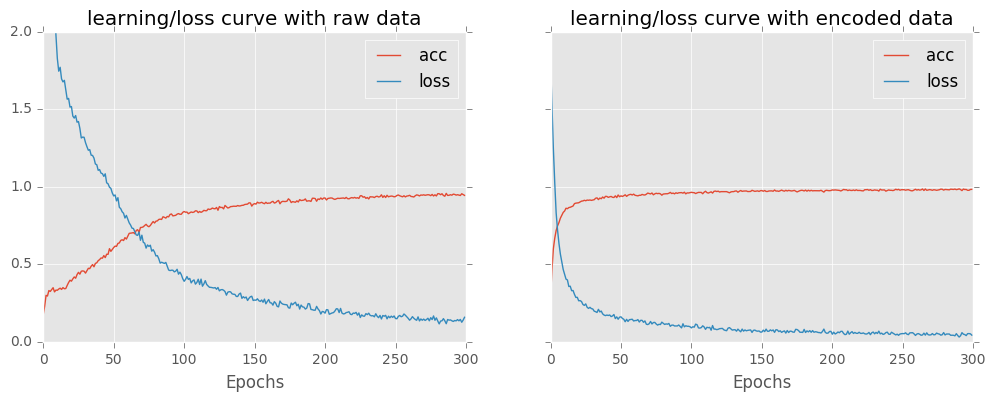

In [42]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))

ax1.plot(history.history['acc'], label='acc')
ax1.plot(history.history['loss'], label='loss')
ax1.set_ylim([0,2])
ax1.legend()
ax1.set_xlabel('Epochs')
ax1.set_title('learning/loss curve with raw data')

ax2.plot(history2.history['acc'], label='acc')
ax2.plot(history2.history['loss'], label='loss')
ax2.legend()
ax2.set_xlabel('Epochs')
ax2.set_title('learning/loss curve with encoded data')

plt.show()

## Summary

In [43]:
raw_values = [
    ('linear model', linear_score, 'red'), 
    ('non-linear svm', svm_score, 'yellow'),
    ('knn', knn_score, 'blue'), 
    ('random forest', tree_score, 'green'), 
    ('neural network',accuracy, 'magenta')
]
encoded_values = [
    ('linear model',linear_score2, 'red'), 
    ('non-linear svm', svm_score2, 'yellow'),
    ('knn',knn_score2, 'blue'), 
    ('random forest', tree_score2, 'green'), 
    ('neural network',accuracy2, 'magenta')
]

# sort model names and scores
raw_models = [i[0] for i in sorted(raw_values, key=lambda x: x[1])]
raw_scores = [i[1] for i in sorted(raw_values, key=lambda x: x[1])]
raw_colors = [i[2] for i in sorted(raw_values, key=lambda x: x[1])]

encoded_models = [i[0] for i in sorted(encoded_values, key=lambda x: x[1])]
encoded_scores = [i[1] for i in sorted(encoded_values, key=lambda x: x[1])]
encoded_colors = [i[2] for i in sorted(encoded_values, key=lambda x: x[1])]

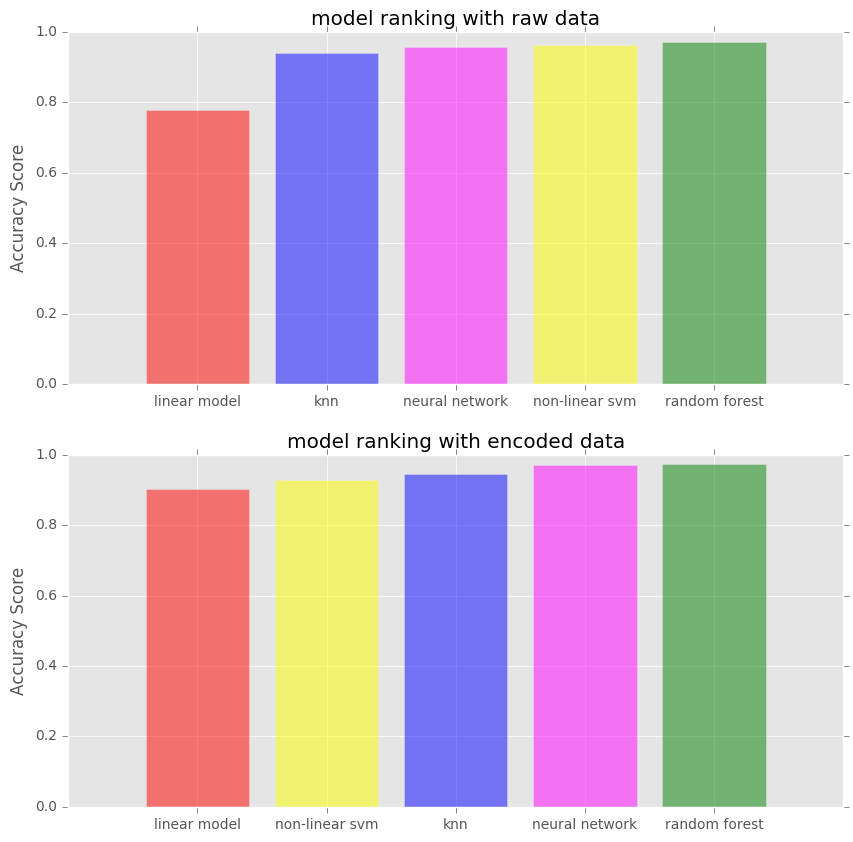

In [45]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(10,10))

y = range(len(raw_models))
ax1.bar(y, raw_scores, align='center', alpha=0.5, color=raw_colors)
ax1.set_ylabel('Accuracy Score')
ax1.set_xticks(y)
ax1.set_xticklabels(raw_models)
ax1.set_title('model ranking with raw data')

y2 = range(len(encoded_models))
ax2.bar(y2, encoded_scores, align='center', alpha=0.5, color=encoded_colors)
ax2.set_ylabel('Accuracy Score')
ax2.set_xticks(y2)
ax2.set_xticklabels(encoded_models)
ax2.set_title('model ranking with encoded data')

plt.show()